In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from vec2Unitary import vec2Unitary
from jax.config import config
from jax.scipy.linalg import expm
config.update("jax_enable_x64", True)

np.random.seed(1)

def print_matrix(mat):
    with np.printoptions(precision=3, suppress=True):
        print(mat)

def assert_equal(mat1,mat2,eps = 0.0000001):
    assert jnp.sum((mat1-mat2)**2) < eps

/Users/qwe/miniforge3/lib/python3.8/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
N = 4
beta = 1
J = 0.5
h = 0.3
layer_num = 4
uniParas_num = layer_num * (2**(2*N)-1)

sigma_z = jnp.array([[1,0],[0,-1]])
sigma_x = jnp.array([[0,1],[1,0]])
sigma_y = jnp.array([[0,1j],[1j,0]])

spin = jnp.array([0,1])
spin_up = jnp.array([[1],[0]])
spin_down= jnp.array([[0],[1]])


In [3]:
#def createH(J,h)

H = jnp.zeros((2**N,2**N))

initLattice = jnp.kron(sigma_z,sigma_z)
for i in range(2,N):
    initLattice = jnp.kron(initLattice,jnp.eye(2))

H += - J * initLattice

for lattice_point in range(1,N-1):
    curr = jnp.eye(2)
    for i in range(1,lattice_point):
        curr = jnp.kron(curr,jnp.eye(2))
    curr = jnp.kron( jnp.kron(curr,sigma_z),sigma_z)
    for i in range(lattice_point+2,N):
        curr = jnp.kron(curr,jnp.eye(2))
    
    assert curr.shape[0] == H.shape[0]
    
    H += -J * curr


initLattice = sigma_x
for i in range(1,N):
    initLattice = jnp.kron(initLattice,jnp.eye(2))

H += - h * initLattice

for lattice_point in range(1,N-1):
    curr = jnp.eye(2)
    for i in range(1,lattice_point):
        curr = jnp.kron(curr,jnp.eye(2))
    curr = jnp.kron(curr,sigma_x)
    for i in range(lattice_point+1,N):
        curr = jnp.kron(curr,jnp.eye(2))
    
    assert curr.shape[0] == H.shape[0]
    
    H += -h * curr

H = jnp.array(H,dtype=jnp.complex128)

In [4]:
# prepare the ensemble basis

formator = '{0:' + '0' + str(N)  +'b}'

state_in_str = [formator.format(i) for i in range(2**N)]


def state_to_vec(s):
    # return a probability with the corresponding state
    if s[0] == '1':
        state = spin_up
        state_mat = spin_up
    else:
        state = spin_down
        state_mat = spin_down
    
    for curr in s[1:]:
        if curr == '1':
            state = jnp.kron(state,spin_up)
            state_mat = jnp.hstack((state_mat,spin_up))
        else:
            state = jnp.kron(state,spin_down)
            state_mat = jnp.hstack((state_mat,spin_down))
    
    return state,state_mat

allstate = jnp.stack([state_to_vec(s)[0] for s in state_in_str])
allstateMat = jnp.stack([state_to_vec(s)[1] for s in state_in_str])


In [5]:
# Utilities

@jax.jit
def stateMat_to_prob(state_mat,probs):
    prob_mat = jnp.multiply(probs,state_mat)
    prob_state = prob_mat[0,:] + prob_mat[1,:]
    return jnp.prod(prob_state)

@jax.jit
def build_ensemble(px,uni):
    single = lambda p,state: p * uni @ jnp.outer(state,state) @  uni.conjugate().T
    mats = jax.vmap(single,(0,0),0)(px,allstate)
    return jnp.sum(mats, axis=0)

@jax.jit
def weighted_expected(operator,px):
    single = lambda state: state.T @ operator @ state
    expectedVs =  jax.vmap(single)(allstate)
    res = jnp.sum(jnp.multiply(expectedVs[:,0,0],px))
    return jnp.real(res)

@jax.jit
def mat_prod(carry,x):
    return carry @ x ,0

@jax.jit
def unitary_prods(uniVec):
    uniVec = uniVec.reshape((layer_num,(2**(2*N)-1)))
    unis = jax.vmap(vec2Unitary,in_axes=(None,0))(N,uniVec)

    res,_ = jax.lax.scan(mat_prod,jnp.eye(2**N,dtype=jnp.complex128),unis)
    return res


stateMat_to_prob_map = jax.vmap(stateMat_to_prob,(0,None),0)

Free parameters initialization:

In [6]:
eps = jnp.array(0.5 * np.random.rand(N))
uniVec = jnp.array(np.random.rand(uniParas_num))
paras = jnp.hstack((eps,uniVec))

In [7]:
def ising(paras):
    eps = paras[:N]
    uniVec = paras[N:]

    p_down = 1/(1+jnp.exp(-beta * eps))
    p_up = jnp.exp(-beta * eps)/(1+jnp.exp(-beta * eps))
    probs = jnp.vstack((p_down,p_up))

    px = stateMat_to_prob_map(allstateMat,probs)
    unitary = unitary_prods(uniVec)
    operator = unitary.conjugate().T @ H @ unitary

    entropy = jnp.sum(jnp.multiply(px,jnp.log(px)))
    loss = entropy + beta* weighted_expected(operator,px)
    #print(entropy)
    return loss




ising(paras),jax.grad(ising)(paras).shape
#ising(paras)



(DeviceArray(-2.71075407, dtype=float64), (1024,))

In [8]:
import scipy.optimize

def value_and_grad_numpy(f):
    def val_grad_f(*args):
        value, grad = jax.value_and_grad(f)(*args)
        return np.float64(value), np.array(grad,dtype=np.float64)
    return val_grad_f
results = scipy.optimize.minimize(value_and_grad_numpy(ising), np.array(paras,dtype=np.float64),
                                  method='L-BFGS-B', jac=True)
print("success:", results.success, "\nniterations:", results.nit, "\nfinal loss:", results.fun)

success: True 
niterations: 147 
final loss: -3.2436713770210712


In [9]:
-jnp.log(jnp.trace(expm(- beta * H)))

DeviceArray(-3.25023374-0.j, dtype=complex128)

In [10]:
# get all inner stuff
paras = jnp.array(results.x)

eps = paras[:N]
uniVec = paras[N:]

p_down = 1/(1+jnp.exp(-beta * eps))
p_up = jnp.exp(-beta * eps)/(1+jnp.exp(-beta * eps))
probs = jnp.vstack((p_down,p_up))

px = stateMat_to_prob_map(allstateMat,probs)
unitary = unitary_prods(uniVec)
operator = unitary.conjugate().T @ H @ unitary

entropy = jnp.sum(jnp.multiply(px,jnp.log(px)))
loss = entropy + beta* weighted_expected(operator,px)

In [11]:
jnp.sum(px)

DeviceArray(1., dtype=float64)

In [12]:
ensemble = build_ensemble(px,unitary)

@jax.jit
def absorbedState(allstate,unitary):
    transUni = unitary.T.conjugate()
    leftFun = lambda state: unitary @ state
    rightFun = lambda state:  state.T @ transUni
    res = jax.vmap(leftFun)(allstate)
    return res

mStates = absorbedState(allstate,unitary)

In [55]:
energies = jnp.linalg.eig(H)[0]
energies

DeviceArray([-1.68373737+0.j,  1.68373737+0.j, -1.68373737+0.j,
              1.68373737+0.j, -0.96856476+0.j, -0.96856476+0.j,
              0.96856476+0.j,  0.96856476+0.j, -0.51754699+0.j,
             -0.19762562+0.j, -0.51754699+0.j, -0.19762562+0.j,
              0.19762562+0.j,  0.19762562+0.j,  0.51754699+0.j,
              0.51754699+0.j], dtype=complex128)

In [25]:
errs = (jnp.sort(jnp.log(px) - (jnp.mean(jnp.log(px)) - jnp.mean(energies))) - jnp.sort(energies))/jnp.sort(energies)
errs = np.real(np.array(errs))


array([ 0.05403876, -0.09511688, -0.04899995, -0.04903251,  0.29450312,
        0.29444219, -0.07054226, -0.65867647, -0.65867647, -0.07054226,
        0.29444219,  0.29450312, -0.04903251, -0.04899995, -0.09511688,
        0.05403876])

In [46]:
stateEstEnergy = [state.T.conjugate() @ H @ state for state in mStates]
errs = (jnp.sort(jnp.array(stateEstEnergy)[:,0,0]) - jnp.sort(energies))/jnp.sort(energies)

In [45]:
jnp.sort(jnp.array(stateEstEnergy)).shape

(16, 1, 1)

In [56]:
qwe, real = jnp.real(jnp.sort(jnp.array(stateEstEnergy)[:,0,0])), jnp.real(jnp.sort(energies))
qwe,real,(qwe-real)/real

(DeviceArray([-1.68373737, -1.68373733, -0.96856474, -0.96856473,
              -0.51754699, -0.51754694, -0.19762526, -0.19762276,
               0.1976227 ,  0.19762576,  0.5175481 ,  0.5175488 ,
               0.968563  ,  0.96856351,  1.68373711,  1.68373714],            dtype=float64),
 DeviceArray([-1.68373737, -1.68373737, -0.96856476, -0.96856476,
              -0.51754699, -0.51754699, -0.19762562, -0.19762562,
               0.19762562,  0.19762562,  0.51754699,  0.51754699,
               0.96856476,  0.96856476,  1.68373737,  1.68373737],            dtype=float64),
 DeviceArray([-2.40300300e-09, -2.68251099e-08, -2.39404291e-08,
              -2.66910791e-08, -7.74781348e-09, -9.43965373e-08,
              -1.80815379e-06, -1.44750770e-05, -1.47523003e-05,
               7.21286445e-07,  2.13527009e-06,  3.49911134e-06,
              -1.82075999e-06, -1.29491243e-06, -1.55918632e-07,
              -1.37796564e-07], dtype=float64))

Text(0.5, 0, 'Energy Level')

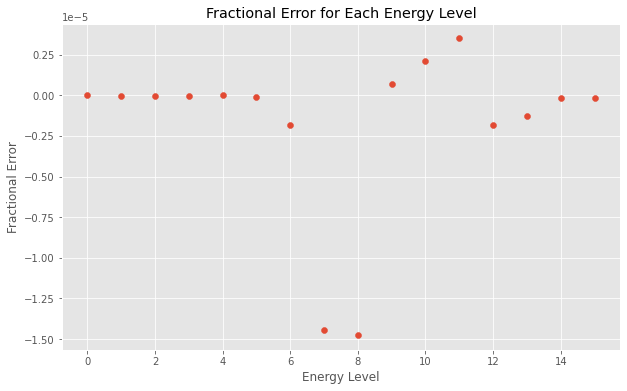

In [57]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
errs =(qwe-real)/real
plt.figure(figsize=(10, 6))
plt.scatter(range(errs.shape[0]),errs)
plt.title("Fractional Error for Each Energy Level")
plt.ylabel("Fractional Error")
plt.xlabel("Energy Level")


In [13]:
# trivial calculation

energies = jnp.linalg.eig(H)[0]
states = jnp.linalg.eig(H)[1]

allSx = sigma_x.copy()
for i in range(N-1):
    allSx = jnp.kron(allSx,sigma_x)

omega = 0.451
sf = 0
eps = 10e-3
ops = allSx

for m in range(2**N):
    for m_p in range(2**N):

        if (energies[m_p] - energies[m] - omega) > eps:
            continue

        elem = states[:,m_p].T.conjugate() @ ops @ states[:,m]

        sf += jnp.exp(-energies[m_p] * beta) * elem * elem.conjugate()

sf/jnp.trace(expm(- beta * H))

DeviceArray(1.01378431+0.j, dtype=complex128)

In [13]:

# sum of the energies is 0
jnp.sum(jnp.hstack([(allstate[i].T @ H @ allstate[i])[0] for i in range(2**N)]))

es = []
for m in range(2**N):
    for m_p in range(2**N):

        es += [energies[m_p] - energies[m]]
uniqueEDeltas = jnp.unique(jnp.abs(jnp.array(es).round(decimals=4)))
uniqueEDeltas

DeviceArray([0.    , 0.3199, 0.3953, 0.451 , 0.7152, 0.7709, 1.0351,
             1.1662, 1.4861, 1.8814, 1.9371, 2.2013, 2.6523, 3.3675],            dtype=float64)

In [14]:
# estimation

energies = [state.T.conjugate() @ H @ state for state in mStates]
states = mStates

sf = 0
for m in range(2**N):
    for m_p in range(2**N):

        if (energies[m_p] - energies[m] - omega) > eps:
            continue

        elem = states[:,m_p].T.conjugate() @ ops @ states[:,m]

        sf += jnp.exp(-energies[m_p] * beta) * elem * elem.conjugate() 

sf/jnp.exp(-loss)

DeviceArray([[0.81563282-1.93746254e-17j]], dtype=complex128)

### Put it all together

In [74]:
def strFactor(energies,states,omega,Z,ops):
    eps = 10e-3
    sf = 0
    for m in range(2**N):
        for m_p in range(2**N):
            #print(omega,energies[m_p] - energies[m]- omega)
            #if (energies[m_p] - energies[m] - omega) > eps:
                #print('jump')
                #continue
            
            diracD = (1/jnp.pi) * (eps/((energies[m_p] - energies[m] - omega)**2 + eps**2))
            elem = states[:,m_p].T.conjugate() @ ops @ states[:,m]

            #sf += jnp.exp(-energies[m_p] * beta) * elem * elem.conjugate() *diracD
            sf +=  elem * elem.conjugate() *diracD

            #if np.abs(energies[m_p] - energies[m] - omega) < 0.1:
                #print("close",energies[m_p] - energies[m],sf,elem)

    return jnp.real(sf/Z).flatten()[0]

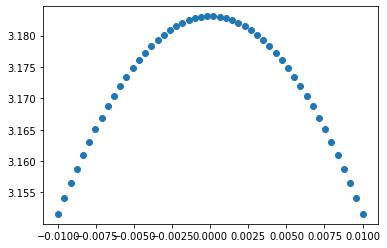

In [33]:
eps = 10e-2
diracD = lambda x: (1/jnp.pi) * (eps/((x**2 + eps**2)))

xs = np.linspace(-0.01,0.01)
ys = np.array([diracD(x) for x in xs])
plt.scatter(xs,ys)

In [93]:
exactEnergies = jnp.linalg.eig(H)[0]
exactStates = jnp.linalg.eig(H)[1]

estEnergies = [state.T.conjugate() @ H @ state for state in mStates]
estStates = mStates[:,:,0]

exactZ =jnp.trace(expm(- beta * H))
estZ = jnp.exp(-loss)

allSy = sigma_y.copy()
for i in range(N-1):
    allSy = jnp.kron(allSy,sigma_y)

allSy = np.random.rand(2**N,2**N)



omegaList = jnp.linspace(0.01,3,num=400)
exactSF = [strFactor(exactEnergies,exactStates,omega,exactZ,allSx) for omega in omegaList]


In [94]:
estSF = [strFactor(estEnergies,estStates.T,omega,estZ,allSx) for omega in omegaList]

Text(0.5, 1.0, 'Dynamic Structure Factor Spectrum of $\\bigotimes S_x$')

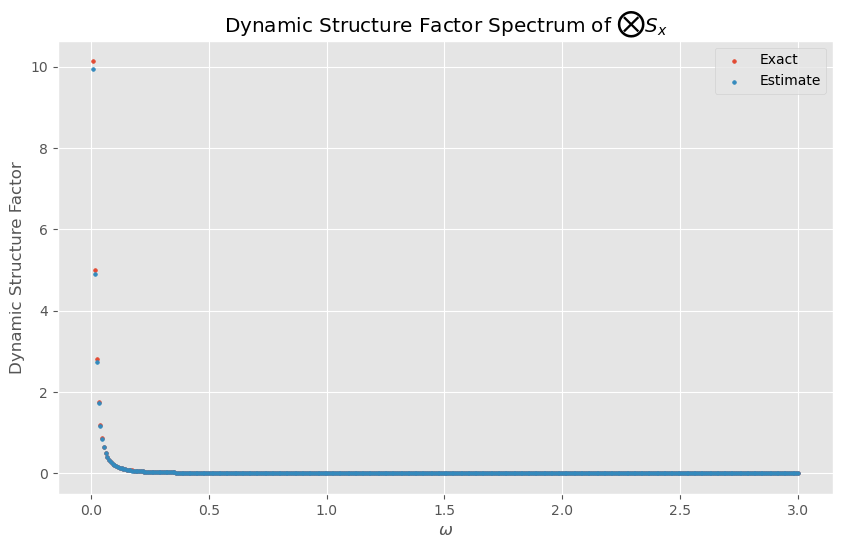

In [95]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10, 6), dpi=100)

plt.scatter(omegaList,exactSF,s=7, label = 'Exact')
plt.scatter(omegaList,estSF,s=7, label = 'Estimate')
plt.xlabel(r'$\omega$')
plt.ylabel("Dynamic Structure Factor")
plt.legend()
plt.title(r"Dynamic Structure Factor Spectrum of $\bigotimes S_x$")

In [48]:
strFactor(exactEnergies,exactStates.T,0.3199,exactZ,allSx)

close (0.31992137235513274+0j) (2.6161792933953665+0j) (0.3794546674313632+0j)
close (0.3199213723551326+0j) (3.5754415630049485+0j) (-0.4965709139161847+0j)
close (0.39525123798180173+0j) (3.6183497242475506+0j) (0.0697102172533271+0j)
close (0.3952512379818013+0j) (3.6348463199853924+0j) (0.09950127497098304+0j)
close (0.3199213723551334+0j) (3.792451909520971+0j) (-0.011221925120229482+0j)
close (0.3199213723551333+0j) (3.8416325700758915+0j) (0.007437020138467734+0j)
close (0.3952512379818018+0j) (3.897370246279527+0j) (-0.03225903420852831+0j)
close (0.3952512379818014+0j) (3.9225704818792053+0j) (0.12297979939751108+0j)
close (0.31992137235513185+0j) (4.104476265835863+0j) (-0.10862356904726608+0j)
close (0.3199213723551315+0j) (4.114068268515655+0j) (0.0711071861680294+0j)
close (0.3199213723551323+0j) (4.297408883878698+0j) (0.2858407575075017+0j)
close (0.31992137235513196+0j) (4.7934512350949205+0j) (0.5113499598471645+0j)


DeviceArray(0.19181989, dtype=float64)

In [49]:
uniqueEDeltas

DeviceArray([0.    , 0.3199, 0.3953, 0.451 , 0.7152, 0.7709, 1.0351,
             1.1662, 1.4861, 1.8814, 1.9371, 2.2013, 2.6523, 3.3675],            dtype=float64)

In [24]:
-jnp.log(px),jnp.sort(exactEnergies)

(DeviceArray([1.72154735, 2.57516667, 2.57519821, 3.42881753, 3.31258714,
              4.16620647, 4.166238  , 5.01985733, 1.47040842, 2.32402774,
              2.32405927, 3.1776786 , 3.06144821, 3.91506753, 3.91509907,
              4.76871839], dtype=float64),
 DeviceArray([-1.68373737+0.j, -1.68373737+0.j, -0.96856476+0.j,
              -0.96856476+0.j, -0.51754699+0.j, -0.51754699+0.j,
              -0.19762562+0.j, -0.19762562+0.j,  0.19762562+0.j,
               0.19762562+0.j,  0.51754699+0.j,  0.51754699+0.j,
               0.96856476+0.j,  0.96856476+0.j,  1.68373737+0.j,
               1.68373737+0.j], dtype=complex128))

In [113]:
allSy = sigma_y.copy()
for i in range(N-1):
    allSy = jnp.kron(allSy,sigma_y)

exactSF = [strFactor(exactEnergies,exactStates,omega,exactZ,jnp.identity(2**N)) for omega in uniqueEDeltas]
estSF = [strFactor(estEnergies,estStates.T,omega,estZ,jnp.identity(2**N)) for omega in uniqueEDeltas]
np.array(exactSF),np.array(estSF).flatten()

(array([1.02483093, 1.02483093, 1.02483093, 1.02483093, 1.02483093,
        1.02483093, 1.02483093, 1.02483093, 1.02483093, 1.02483093,
        1.02483093, 1.02483093, 1.02483093, 1.02483093, 1.02483093]),
 array([1.00658384, 1.00658384, 1.00658384, 1.00658384, 1.00658384,
        1.00658384, 1.00658384, 1.00658384, 1.00658384, 1.00658384,
        1.00658384, 1.00658384, 1.00658384, 1.00658384, 1.00658384]))

In [111]:
#strFactor(exactEnergies,exactStates,omega,exactZ,allSx)
np.array(exactSF),np.array(estSF).flatten()

(array([1.01378431, 1.01378431, 1.01378431, 1.01378431, 1.01378431,
        1.01378431, 1.01378431, 1.01378431, 1.01378431, 1.01378431,
        1.01378431, 1.01378431, 1.01378431, 1.01378431, 1.01378431]),
 array([1.00658291, 1.00658299, 1.00658356, 1.00658356, 1.00658381,
        1.00658383, 1.00658383, 1.00658384, 1.00658384, 1.00658384,
        1.00658384, 1.00658384, 1.00658384, 1.00658384, 1.00658384]))

In [30]:
allstate[2].T @ allSx @ allstate[1]

DeviceArray([[0]], dtype=int64)

In [40]:
jnp.where(allSx != 0 )[0]

DeviceArray([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
              12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
              24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
              36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
              48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
              60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
              72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
              84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
              96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
             108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
             120, 121, 122, 123, 124, 125, 126, 127], dtype=int64)

DeviceArray([[0, 0, 0, ..., 0, 0, 1],
             [0, 0, 0, ..., 0, 1, 0],
             [0, 0, 0, ..., 1, 0, 0],
             ...,
             [0, 0, 1, ..., 0, 0, 0],
             [0, 1, 0, ..., 0, 0, 0],
             [1, 0, 0, ..., 0, 0, 0]], dtype=int64)